# Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
#from matplotlib import pyplot as plt
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.preprocessing import LabelEncoder

#%matplotlib inline

# Read Data

In [ ]:
address=pd.read_csv('addresses.csv',engine='python')
latlon=pd.read_csv('latlons.csv',engine='python')
df=pd.read_csv('train.csv',engine='python')
test_df=pd.read_csv('test.csv',engine='python')

In [ ]:
df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,payment_amount,balance_due,payment_date,payment_status,collection_status,grafitti_status,compliance_detail,compliance,address,lat,lon
0,22056,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INVESTMENT INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WICKER,CHICAGO,IL,60606,NaN,USA,2004-03-16 11:40:00,2005-03-21 10:30:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
1,77242,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","INV. INC., MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,IL,60606,NaN,USA,2006-05-24 09:00:00,2006-06-27 15:00:00,9-1-36(a),Failure of owner to obtain certificate of comp...,Responsible by Default,500.0,20.0,10.0,50.0,0.0,0.0,580.0,0.0,580.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
2,77243,"Buildings, Safety Engineering & Env Department","Sims, Martinzie","MORTGAGE CO., MIDWEST",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,IL,60606,NaN,USA,2006-05-24 09:00:00,2006-06-27 15:00:00,9-1-81(a),Failure to obtain certificate of registration ...,Responsible by Default,250.0,20.0,10.0,25.0,0.0,0.0,305.0,0.0,305.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
4,138219,Department of Public Works,"Talbert, Reginald","INVESTMENT INC, MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S WACKER #1418,CHICAGO,IL,60606,NaN,USA,2007-09-21 14:45:00,2008-02-05 10:30:00,9-1-105,Rodent harborage one-or two-family dwelling or...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,0.0,140.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268
5,177558,"Buildings, Safety Engineering & Env Department","Morris, John","INVESTMENT, MIDWEST MORTGAGE",2900.0,TYLER,NaN,3.0,S. WACKER,CHICAGO,IL,60606,NaN,USA,2008-06-13 10:00:00,2008-09-03 09:00:00,19450901,Failure of owner to comply with an emergency o...,Responsible by Default,300.0,20.0,10.0,30.0,0.0,0.0,360.0,0.0,360.0,NaN,NO PAYMENT APPLIED,NaN,NaN,non-compliant by no payment,0.0,"2900 tyler, Detroit MI",42.390729,-83.124268


In [ ]:
test_df.head()

,ticket_id,agency_name,inspector_name,violator_name,violation_street_number,violation_street_name,violation_zip_code,mailing_address_str_number,mailing_address_str_name,city,state,zip_code,non_us_str_code,country,ticket_issued_date,hearing_date,violation_code,violation_description,disposition,fine_amount,admin_fee,state_fee,late_fee,discount_amount,clean_up_cost,judgment_amount,grafitti_status
0,284932,Department of Public Works,"Granberry, Aisha B","FLUELLEN, JOHN A",10041.0,ROSEBERRY,NaN,141,ROSEBERRY,DETROIT,MI,48213,NaN,USA,2012-01-04 14:00:00,2012-01-19 09:00:00,22-2-61,Failure to secure City or Private solid waste ...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
1,285362,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,1000.0,20.0,10.0,100.0,0.0,0.0,1130.0,NaN
2,285361,Department of Public Works,"Lusk, Gertrina","WHIGHAM, THELMA",18520.0,EVERGREEN,NaN,19136,GLASTONBURY,DETROIT,MI,48219,NaN,USA,2012-01-05 09:50:00,2012-02-06 09:00:00,22-2-43,Improper placement of Courville container betw...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN
3,285338,Department of Public Works,"Talbert, Reginald","HARABEDIEN, POPKIN",1835.0,CENTRAL,NaN,2246,NELSON,WOODHAVEN,MI,48183,NaN,USA,2012-01-05 10:25:00,2012-02-07 09:00:00,22-2-88(b),Allowing bulk solid waste to lie or accumulate...,Responsible by Default,200.0,20.0,10.0,20.0,0.0,0.0,250.0,NaN
4,285346,Department of Public Works,"Talbert, Reginald","CORBELL, STANLEY",1700.0,CENTRAL,NaN,3435,MUNGER,LIVONIA,MI,48154,NaN,USA,2012-01-05 10:20:00,2012-02-14 09:00:00,22-2-45,Violation of time limit for approved container...,Responsible by Default,100.0,20.0,10.0,10.0,0.0,0.0,140.0,NaN


In [ ]:
address.head()

,ticket_id,address
0,22056,"2900 tyler, Detroit MI"
1,27586,"4311 central, Detroit MI"
2,22062,"1449 longfellow, Detroit MI"
3,22084,"1441 longfellow, Detroit MI"
4,22093,"2449 churchill, Detroit MI"


In [ ]:
latlon.head()

,address,lat,lon
0,"4300 rosa parks blvd, Detroit MI 48208",42.346169,-83.079962
1,"14512 sussex, Detroit MI",42.394657,-83.194265
2,"3456 garland, Detroit MI",42.373779,-82.986228
3,"5787 wayburn, Detroit MI",42.403342,-82.957805
4,"5766 haverhill, Detroit MI",42.407255,-82.946295


In [ ]:
df.head()

,agency_name,inspector_name,violation_code,disposition,admin_fee,state_fee,discount_amount,grafitti_status,lat,lon,judge-fine-late_Amount
199161,"Buildings, Safety Engineering & Env Department","Morris, John",9-1-83 - (Dwelling),Responsible by Default,20.0,10.0,0.0,0,42.375211,-83.100609,1130.0
177662,Department of Public Works,"Hayes, Billy J",9-1-110(a),Responsible by Default,20.0,10.0,0.0,0,42.395354,-83.205689,140.0
244868,Department of Public Works,"Havard, Jacqueline",9-1-103(C),Responsible by Default,20.0,10.0,0.0,0,42.380240,-82.999898,250.0
49254,"Buildings, Safety Engineering & Env Department","Sharpe, Anthony",9-1-36(a),Responsible by Determination,20.0,10.0,0.0,0,42.323608,-83.077211,580.0
5783,"Buildings, Safety Engineering & Env Department","DeRamer, Andrew",9-1-36(a),Responsible by Default,20.0,10.0,0.0,0,42.415323,-82.936357,580.0


# Merge DataFrames

In [ ]:
df_address=pd.merge(df,address,on='ticket_id')
df=pd.merge(df_address,latlon,on='address')
df_test_address=pd.merge(test_df,address,on='ticket_id')
test_df=pd.merge(df_test_address,latlon,on='address')

# Data Cleansing

In [ ]:
for col in df:
    cols=df[col].unique()
    print(col,len(cols))



#Change str type features to catogry

category_cols=['agency_name','inspector_name','disposition','grafitti_status','country','state','violation_code']
for col in category_cols :
              df[col]=df[col].astype('category')

#With looking at number of unique values in each field, I decided to use just these features:
X_cols=[
 'agency_name',
 'inspector_name',
 'violation_code',
 'country',
 'state',
 'disposition',
 'fine_amount',
 'admin_fee',
 'state_fee',
 'late_fee',
 'discount_amount',
 'judgment_amount',
 'grafitti_status'
 ,'lat'
 ,'lon']

df=df.dropna(subset=['compliance'])
X=df[X_cols]
y=df['compliance']

ticket_id 250306
agency_name 5
inspector_name 173
violator_name 119993
violation_street_number 19175
violation_street_name 1791
violation_zip_code 1
mailing_address_str_number 15827
mailing_address_str_name 37897
city 5184
state 60
zip_code 4252
non_us_str_code 3
country 5
ticket_issued_date 86979
hearing_date 6223
violation_code 235
violation_description 258
disposition 9
fine_amount 44
admin_fee 2
state_fee 2
late_fee 37
discount_amount 13
clean_up_cost 1
judgment_amount 57
payment_amount 533
balance_due 606
payment_date 2308
payment_status 3
collection_status 2
grafitti_status 2
compliance_detail 10
compliance 3
address 95598
lat 78695
lon 87250


In [ ]:
#Correlation between features
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=0)

corr=X_train.corr()
corr=corr.abs()
corr_un=corr.unstack()
corr_series=corr_un.sort_values(kind='quicksort',ascending=False)

for index, value in corr_series.items():
  if((value>0.8) & (value<1)):
    print(index,value)

#After correlation has been made I decided to delete these columns:

deleted_cols=['judgment_amount','fine_amount','late_fee']
X['judge-fine-late_Amount']=X['judgment_amount']+X['fine_amount']+X['late_fee']
X = X.drop(deleted_cols, axis=1)

#For category type features:

#NA Values:
X=X.fillna(method='ffill')


#X=pd.get_dummies(X)
for col in category_cols:
  X[col]=LabelEncoder().fit_transform(X[col])


#Scaling features
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=0)
scaler=MinMaxScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

('fine_amount', 'judgment_amount') 0.9998932709100479
('judgment_amount', 'fine_amount') 0.9998932709100479
('judgment_amount', 'late_fee') 0.989401570490141
('late_fee', 'judgment_amount') 0.989401570490141
('late_fee', 'fine_amount') 0.9871866411848839
('fine_amount', 'late_fee') 0.9871866411848839


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
X.head()

,agency_name,inspector_name,violation_code,country,state,disposition,admin_fee,state_fee,discount_amount,grafitti_status,lat,lon,judge-fine-late_Amount
0,0,125,143,4,16,2,20.0,10.0,0.0,0,42.390729,-83.124268,580.0
1,0,125,143,4,16,2,20.0,10.0,0.0,0,42.390729,-83.124268,1130.0
2,0,125,179,4,16,2,20.0,10.0,0.0,0,42.390729,-83.124268,580.0
3,1,138,96,4,16,2,20.0,10.0,0.0,0,42.390729,-83.124268,250.0
4,0,93,1,4,16,2,20.0,10.0,0.0,0,42.390729,-83.124268,690.0


# Try Different Algorithms

## Parameter Tuning

Best parameter (CV score=0.633):
{'lc__C': 1000}


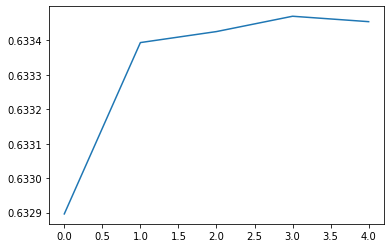

In [ ]:
#For algorithms below, I used GridSearchCV to get the best hyperparameters
#(Here I just show it for Lasso Logistic Regression):

lc=LogisticRegression(penalty='l1', solver='liblinear')

pipe=Pipeline(steps=[('scaler',scaler),('lc',lc)])

param_grid={'lc__C':[1,10,100,1000,10000]}

search=GridSearchCV(pipe,param_grid,scoring='roc_auc')
search.fit(X,y)


#print("Best parameter (CV score=%0.3f):" % search.best_score_)
#print(search.best_params_)


plt_y=search.cv_results_['mean_test_score']
#plt.plot(plt_y)
#plt.show()

# Cross Validation For Each Algrithm

## Lasso Logistic Regression

In [ ]:
Lasso_clf=LogisticRegression(penalty='l1', solver='liblinear',C=1000)
Lasso_pipe=make_pipeline(scaler,Lasso_clf)
Lasso_cv_score=cross_val_score(Lasso_pipe,X,y,scoring="roc_auc")
Lasso_cv_score.mean()

0.6334535248872685

## Ridge Logistic Regression

In [ ]:
Ridge_clf=LogisticRegression(penalty='l2', solver='liblinear',C=100)
Ridge_pipe=make_pipeline(scaler,Ridge_clf)
Ridge_cv_score=cross_val_score(Ridge_pipe,X,y,scoring="roc_auc")
Ridge_cv_score.mean()

0.633286553975634

## Naive Bayes

In [ ]:
NB_clf=GaussianNB()
NB_pipe=make_pipeline(scaler,NB_clf)
NB_cv_score=cross_val_score(NB_pipe,X,y,scoring="roc_auc")
NB_cv_score.mean()

0.7683000653216028

## Random Forest

In [ ]:
RF_clf=RandomForestClassifier(max_depth=10)
RF_pipe=make_pipeline(scaler,RF_clf)
RF_cv_score=cross_val_score(RF_pipe,X,y,scoring="roc_auc")
RF_cv_score.mean()

0.8027654853684961

## Ensemble Algorithms

In [ ]:
Ens_clf=VotingClassifier(estimators=[('rf',RF_clf),('NB',NB_clf)],voting='soft')
Ens_pipe=make_pipeline(scaler,Ens_clf)
Ens_cv_score=cross_val_score(Ens_pipe,X,y,scoring="roc_auc")
Ens_cv_score.mean()

0.7988856148095125

# Predict Test DataFrame

In [ ]:
def blight_model():
  import pandas as pd
  import numpy as np
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.pipeline import make_pipeline
  from sklearn.ensemble import RandomForestClassifier
  from sklearn.preprocessing import LabelEncoder

  address=pd.read_csv('addresses.csv',engine='python')
  latlon=pd.read_csv('latlons.csv',engine='python')
  df=pd.read_csv('train.csv',engine='python')
  test_df=pd.read_csv('test.csv',engine='python')

  df_address=pd.merge(df,address,on='ticket_id')
  df=pd.merge(df_address,latlon,on='address')
  df_test_address=pd.merge(test_df,address,on='ticket_id')
  test_df=pd.merge(df_test_address,latlon,on='address')

  category_cols=['agency_name','disposition','inspector_name','grafitti_status','country','state','violation_code']
  for col in category_cols :
              df[col]=df[col].astype('category')
  for col in category_cols:
              test_df[col]=test_df[col].astype('category')


  X_cols=[
  'agency_name',
  'violation_code',
  'inspector_name',
  'country',
  'state',
  'disposition',
  'fine_amount',
  'admin_fee',
  'state_fee',
  'late_fee',
  'discount_amount',
  'judgment_amount',
  'grafitti_status'
  ,'lat'
  ,'lon']

  df=df.dropna(subset=['compliance'])
  X=df[X_cols]
  X_test_final=test_df[X_cols]
  y=df['compliance']  



  
  deleted_cols=['judgment_amount','fine_amount','late_fee']
  X['judge-fine-late_Amount']=X['judgment_amount']+X['fine_amount']+X['late_fee']
  X = X.drop(deleted_cols, axis=1)

  X_test_final['judge-fine-late_Amount']=X_test_final['judgment_amount']+X_test_final['fine_amount']+X_test_final['late_fee']
  X_test_final = X_test_final.drop(deleted_cols, axis=1)

  #For category type features:

  #NA Values:
  X=X.fillna(method='ffill')
  X_test_final=X_test_final.fillna(method='ffill')


  for col in category_cols:
    total_df=pd.concat([X[col], X_test_final[col]])
    le = LabelEncoder()

    le.fit(total_df.astype(str))
    X[col]=le.transform(X[col].astype(str))
    X_test_final[col]=le.transform(X_test_final[col].astype(str))




  #Scaling features

  scaler=MinMaxScaler()
  X_train_final=scaler.fit_transform(X)
  X_test_final=scaler.transform(X_test_final)

  RF_clf=RandomForestClassifier(max_depth=10,random_state=137)
  RF_clf.fit(X_train_final,y)
  pred_prob=RF_clf.predict_proba(X_test_final)
  pred_prob1=pd.Series(pred_prob[:,1])
  Final_Result=pd.concat([test_df['ticket_id'],pred_prob1],axis=1)
  Final_Result.set_index('ticket_id',inplace=True)

  return Final_Result


In [ ]:
blight_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,ticket_id,0
0,284932,0.080530
1,285362,0.025142
2,285361,0.065867
3,285338,0.075102
4,285346,0.085854
...,...,...
60996,376496,0.014608
60997,376497,0.014608
60998,376499,0.066385
60999,376500,0.066385
